<a href="https://colab.research.google.com/github/VinishUchiha/Fine-Tuning-BERT/blob/master/Document_Classification/fine_tuning_bert_for_doc_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# check the gpu availability and set the device
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')
  print('GPU :',torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')

GPU : Tesla P100-PCIE-16GB


In [0]:
# install huggingface transformers
!pip install transformers

     |████████████████████████████████| 675kB 6.6MB/s 
     |████████████████████████████████| 3.8MB 27.7MB/s 
     |████████████████████████████████| 1.1MB 41.5MB/s 
     |████████████████████████████████| 890kB 43.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=2123f1a82838390b1fc820ebae0fcc9f41ff89e4c4d50fe90e066bbe8b1bff02
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import urllib
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 


def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

                
download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [0]:
# # download the dataset
# !wget https://ndownloader.figshare.com/files/7554634
# !wget https://ndownloader.figshare.com/files/7554637

In [0]:
# read the dataset
import pandas as pd

comments = pd.read_csv('attack_annotated_comments.tsv',sep='\t',index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',sep='\t')

In [0]:
comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


In [0]:
comments[['comment','split']].groupby('split').count()

,comment
split,
dev,23160
test,23178
train,69526


In [0]:
annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


In [0]:
# labels a comment as an atack if the majority of annotators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

# join labels and comments
comments['attack'] = labels

# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [0]:
# divide the dataset into train and test
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

In [0]:
# check whether the dataset are balanced
total_comments = len(comments)
num_attacks = len(comments.query('attack'))

print(f'{num_attacks} in {total_comments} are attacks({num_attacks/total_comments}).')

13590 in 115864 are attacks(0.11729268797900988).


In [0]:
# load the bert tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [0]:
text = train_comments.iloc[0].comment

tokens = tokenizer.tokenize(text)

print(text)
print(len(tokens))

`- This is not ``creative``.  Those are the dictionary definitions of the terms ``insurance`` and ``ensurance`` as properly applied to ``destruction``.  If you don't understand that, fine, legitimate criticism, I'll write up ``three man cell`` and ``bounty hunter`` and then it will be easy to understand why ``ensured`` and ``insured`` are different - and why both differ from ``assured``.  The sentence you quote is absolutely neutral.  You just aren't familiar with the underlying theory of strike-back (e.g. submarines as employed in nuclear warfare) guiding the insurance, nor likely the three man cell structure that kept the IRA from being broken by the British.  If that's my fault, fine, I can fix that to explain.  But ther'es nothing ``personal`` or ``creative`` about it.  I'm tired of arguing with you.  Re: the other article, ``multi-party`` turns up plenty, and there is more use of ``mutually`` than ``mutual``.  If I were to apply your standard I'd be moving ``Mutual Assured Destruc

In [0]:
import numpy as np

input_ids = []
lengths = []

for sen in train_comments.comment:

  if ((len(input_ids) % 20000) == 0):
    print(f'Read {len(input_ids)} comments.')

  encoded_sent = tokenizer.encode(sen,add_special_tokens=True)
  input_ids.append(encoded_sent)
  lengths.append(len(encoded_sent))

print(f'Total {len(input_ids)} comments.')

In [0]:
labels = train_comments.attack.to_numpy().astype(int)

print(f'{np.sum(labels)} positive')
print(f'{len(labels)-np.sum(labels)} negative')

8079 positive
61447 negative


In [0]:
print('Min Length :',min(lengths))
print('Max Length :',max(lengths))
print('Median Length :',np.median(lengths))

Min Length : 2
Max Length : 9861
Median Length : 52.0


In [0]:
#pad and truncate the comments
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 128

input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype='long',value=0,truncating='post',padding='post')

Using TensorFlow backend.


In [0]:
#create attention masks
attention_masks = []

#if the token id is 0,its padding,set the mask to 0
#if the token id is greater the 0,its real token,set the mask to 1
for sent in input_ids:
  attn_mask = [int(token_id > 0) for token_id in sent]
  attention_masks.append(attn_mask)

In [0]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,labels,random_state=42,test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks,labels,random_state=42,test_size=0.1)

In [0]:
# convert all values to torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoaders for our training and validation sets.
train_dataset = TensorDataset(train_inputs,train_masks,train_labels)
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
val_dataset = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size
        )

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

#Helper Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [27]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch in range(epochs):
  print('Epoch :',epoch+1)
  t0 = time.time()

  total_loss = 0
  model.train()

  for step, batch in enumerate(train_dataloader):

    if step % 100 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print(f'Batch {step} of {len(train_dataloader)}  Elapsed: {elapsed}')

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,token_type_ids=None,attention_mask=b_input_mask,labels=b_labels)
    loss = outputs[0]

    total_loss += loss.item()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
    optimizer.step()
    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)
  loss_values.append(avg_train_loss)

  print(f'Average Train Loss: {avg_train_loss} Training Epoch Time: {format_time(time.time()-t0)}')

  # Validation
  t0 = time.time()
  model.eval()

  eval_loss = 0
  eval_accuracy = 0
  nb_eval_steps = 0
  np_eval_examples = 0

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids,b_input_mask,b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,token_type_ids=None,attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits,label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps +=1

  print(f'Validation Accuracy: {eval_accuracy/nb_eval_steps} Validation Time: {format_time(time.time()-t0)}')
print('Trining Complete')

Epoch : 1
Batch 100 of 1956  Elapsed: 0:00:39
Batch 200 of 1956  Elapsed: 0:01:18
Batch 300 of 1956  Elapsed: 0:01:57
Batch 400 of 1956  Elapsed: 0:02:36
Batch 500 of 1956  Elapsed: 0:03:15
Batch 600 of 1956  Elapsed: 0:03:53
Batch 700 of 1956  Elapsed: 0:04:32
Batch 800 of 1956  Elapsed: 0:05:11
Batch 900 of 1956  Elapsed: 0:05:50
Batch 1000 of 1956  Elapsed: 0:06:29
Batch 1100 of 1956  Elapsed: 0:07:08
Batch 1200 of 1956  Elapsed: 0:07:46
Batch 1300 of 1956  Elapsed: 0:08:25
Batch 1400 of 1956  Elapsed: 0:09:04
Batch 1500 of 1956  Elapsed: 0:09:43
Batch 1600 of 1956  Elapsed: 0:10:22
Batch 1700 of 1956  Elapsed: 0:11:00
Batch 1800 of 1956  Elapsed: 0:11:39
Batch 1900 of 1956  Elapsed: 0:12:18
Average Train Loss: 0.13834195320231646 Training Epoch Time: 0:12:40
Validation Accuracy: 0.9566290774719673 Validation Time: 0:00:25
Epoch : 2
Batch 100 of 1956  Elapsed: 0:00:39
Batch 200 of 1956  Elapsed: 0:01:18
Batch 300 of 1956  Elapsed: 0:01:56
Batch 400 of 1956  Elapsed: 0:02:35
Batch 50

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
No handles with labels found to put in legend.


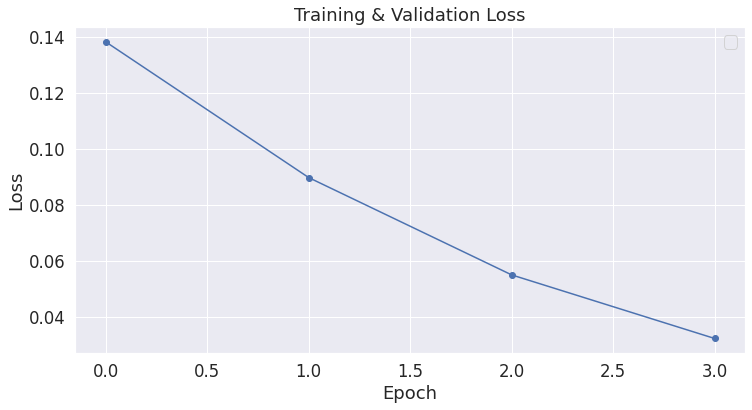

In [28]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [36]:
# check the performance of the model using test set
test_input_ids = []


for sen in test_comments.comment:

  if ((len(input_ids) % 20000) == 0):
    print(f'Read {len(input_ids)} comments.')

  encoded_sent = tokenizer.encode(sen,add_special_tokens=True,max_length=MAX_LEN)
  test_input_ids.append(encoded_sent)


print(f'Total {len(test_input_ids)} comments.')

test_labels = test_comments.attack.to_numpy().astype(int)

print(f'{np.sum(test_labels)} positive')
print(f'{len(test_labels)-np.sum(test_labels)} negative')

Total 23178 comments.
2756 positive
20422 negative


In [0]:
test_input_ids = pad_sequences(test_input_ids,maxlen=MAX_LEN,dtype='long',
                               truncating='post',padding='post')

#create attention masks
test_attention_masks = []

#if the token id is 0,its padding,set the mask to 0
#if the token id is greater the 0,its real token,set the mask to 1
for sent in test_input_ids:
  attn_mask = [float(token_id > 0) for token_id in sent]
  test_attention_masks.append(attn_mask)

#convert to tensors
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

In [0]:
batch_size = 32

#create the test dataloader
test_dataset = TensorDataset(test_inputs,test_masks,test_labels)
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size
        )

In [39]:
# predictions on test set
print(f'Predicting labels for {len(test_inputs)} test sentence')
model.eval()

predictions,true_labels = [], []

t0 = time.time()

for step , batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)

  if step % 100 == 0 and not step == 0:
    elapsed = format_time(time.time() - t0)
    print(f'Batch {step} of {len(test_dataloader)}  Elapsed: {elapsed}')
  
  b_input_ids,b_input_mask,b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,token_type_ids=None,attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)
print('completed')

Predicting labels for 23178 test sentence
Batch 100 of 725  Elapsed: 0:00:12
Batch 200 of 725  Elapsed: 0:00:23
Batch 300 of 725  Elapsed: 0:00:35
Batch 400 of 725  Elapsed: 0:00:47
Batch 500 of 725  Elapsed: 0:00:58
Batch 600 of 725  Elapsed: 0:01:10
Batch 700 of 725  Elapsed: 0:01:22
completed


In [0]:
# combine the results across the batches
predictions = np.concatenate(predictions,axis=0)
true_labels = np.concatenate(true_labels,axis=0)

In [42]:
predictions[0:5]

array([[ 4.5872383, -4.577865 ],
       [ 4.626062 , -4.3941045],
       [ 4.7028956, -4.667826 ],
       [ 4.665033 , -4.609816 ],
       [ 4.361679 , -4.0260224]], dtype=float32)

In [43]:
true_labels[0:5]

array([0, 0, 0, 0, 0])

In [44]:
from sklearn.metrics import roc_auc_score

#use the model output for label 1 as predictions
p1 = predictions[:,1]

auc = roc_auc_score(true_labels,p1)

print(f'ROC AUC score for test set: {auc}')

ROC AUC score for test set: 0.9686934421016977


In [45]:
import os

output_dir = './saved_model/'

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

model_to_save = model.module if hasattr(model,'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./saved_model/vocab.txt',
 './saved_model/special_tokens_map.json',
 './saved_model/added_tokens.json')

In [0]:
gdrive_path = '/content/drive/My Drive/BERT_doc_classification'

if not os.path.exists(gdrive_path):
  os.makedirs(gdrive_path)

!cp -r ./saved_model/ /content/drive/My\ Drive/BERT_doc_classification